In [261]:
import pandas as pd
import numpy as np
import difflib
import re
import requests

In [236]:
hotels = pd.read_csv('./data/hotels.csv')
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [237]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [238]:
'''
# Удаляем строковые значения cоздав пул колонок со строковым значением. 
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)



hotels.info()'''

"\n# Удаляем строковые значения cоздав пул колонок со строковым значением. \nobject_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']\nhotels.drop(object_columns, axis = 1, inplace=True)\n\n\n\nhotels.info()"

In [239]:
#Заполняем пропуски
hotels = hotels.fillna(0)

In [240]:
#Достаем количество дней c момента публикации ревью
def days_num(string_):
    regexp = re.findall(r'\d{0,5}',string_)
    return regexp[0]
hotels['days_since_review'] = hotels['days_since_review'].apply(days_num)

In [241]:
#Стрипуем национальность для будущего присвоения кода страны
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.strip()
#Переименуем пару стран
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace('United States of America','United States')

In [242]:
#Достаем код страны
response = requests.get('https://countrycode.org/')
country_code = pd.read_html(response.text)
country_code = country_code[0]
country_code = country_code[['COUNTRY', 'COUNTRY CODE']]

#Создаем функцию для формирования кодовой строки исходя из принципа территориальной близости принадлежности для кодов формата Х-ХХХ
def get_code(data):
    data = data.split('-')
    return int(data[0])

country_code['COUNTRY CODE'] = country_code['COUNTRY CODE'].apply(get_code)

#Формируем новый фрейм с кодом страны ревьюера
hotels = hotels.merge(country_code, how='left', left_on='reviewer_nationality', right_on='COUNTRY')
hotels = hotels.rename(columns={'COUNTRY CODE':'nationality_code', 'COUNTRY':'country'})
hotels['nationality_code'] = hotels['nationality_code'].fillna(hotels['nationality_code'].mode()[0])

In [327]:
country_list = [x for x in country_code['COUNTRY']]
temp_list = hotels['hotel_address'][6332].split(' ')
for i in temp_list:
    if i in country_list:
        print(i)

France


In [326]:
hotels['hotel_address'][6332]

'9 Rue de Washington 8th arr 75008 Paris France'

In [293]:
country_code['COUNTRY'].iloc[75]

'Gambia'

In [243]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

In [246]:
# непрерывные признаки
num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', 'review_total_positive_word_counts',
            'total_number_of_reviews_reviewer_has_given', 'additional_number_of_scoring', 'days_since_review']

#num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', 'review_total_positive_word_counts',
# 'total_number_of_reviews_reviewer_has_given', 'additional_number_of_scoring', 'reviewer_score', 'days_since_review']

# категориальные признаки
cat_cols = ['average_score', 'lat', 'nationality_code']

#cat_cols = ['average_score', 'lat', 'lng', 'reviewer_nationality',
# 'negative_review', 'positive_review', 'tags', 'hotel_address', 'review_date']


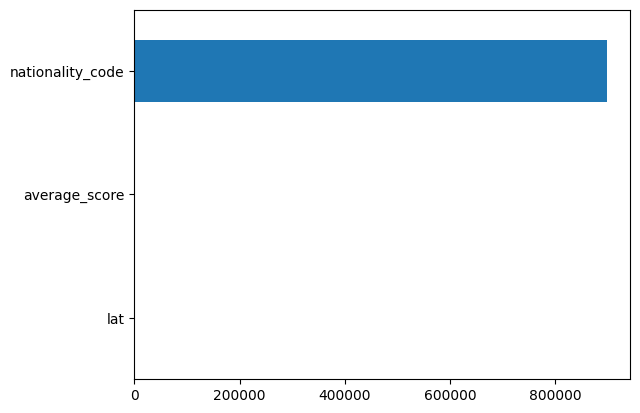

In [247]:
#Оценка влияния категориальных признаков на ключевую переменную
y=y.astype('int')

from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

<AxesSubplot: >

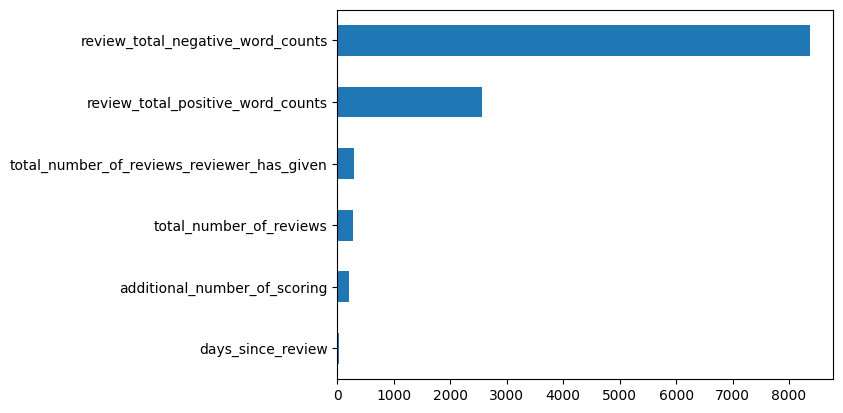

In [248]:
#Оценка влияния непрервных признаков на ключевую переменную
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [ ]:
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)

In [249]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [250]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [251]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


ValueError: could not convert string to float: 'Pla a de Llevant s n Sant Mart 08019 Barcelona Spain'

In [10]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.1413257569305064


Небольшой бонус:


In [11]:
# # убираем признаки которые еще не успели обработать, 
# # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
# object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
# hotels.drop(object_columns, axis = 1, inplace=True)

# # заполняем пропуски самым простым способом
# hotels = hotels.fillna(0)